In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
pd.options.mode.chained_assignment = None

df = pd.read_csv("rawdata.csv", skipinitialspace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24949 entries, 0 to 24948
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DiaChi            24949 non-null  object 
 1   TinhTrangBDS      24924 non-null  object 
 2   DienTich          24917 non-null  object 
 3   Gia/m2            24916 non-null  object 
 4   Phongngu          24926 non-null  object 
 5   TenPhanKhu        7035 non-null   object 
 6   SoTang            6726 non-null   float64
 7   PhongTam          24388 non-null  object 
 8   Loai              24926 non-null  object 
 9   GiayTo            18852 non-null  object 
 10  MaCanHo           3358 non-null   object 
 11  TinhTrangNoiThat  12790 non-null  object 
 12  HuongCuaChinh     9370 non-null   object 
 13  HuongBanCong      8670 non-null   object 
 14  DacDiem           5601 non-null   object 
 15  Gia               24949 non-null  object 
dtypes: float64(1), object(15)
memory usage: 

# Xử lý dữ liệu

In [33]:
#Chỉ lấy diện tích not null và có diện tích trong khoảng 20m2 đến 100m2
df = df[df.DienTich.notnull()]
df = df.reset_index()
for i in range(len(df.DienTich)):
    df.DienTich[i] = float(df.DienTich[i].split(' ')[0])
df = df[(df.DienTich >= 20) & (df.DienTich <= 100)]
df = df.reset_index()

In [34]:
#Chỉ lấy các căn hộ có dữ liệu về phòng ngủ và phòng tắm
df = df[df.SoTang.notnull()]
df = df[df.Phongngu.notnull()]
df = df[df.PhongTam.notnull()]
df = df.reset_index(drop=True)

#Xóa các chữ dư thừa (phòng, nhiều hơn, ...) trong dữ liệu
for i in range(len(df.Phongngu)):
    if "nhiều hơn" in df.Phongngu[i]:
        df.Phongngu[i]= int(df.Phongngu[i].split(' ')[2])+1
    else:
        df.Phongngu[i]= df.Phongngu[i].split(' ')[0]
for i in range(len(df.PhongTam)):
    if "Nhiều hơn" in df.PhongTam[i]:
        df.PhongTam[i]= int(df.PhongTam[i].split(' ')[2])+1
    else:
        df.PhongTam[i]= df.PhongTam[i].split(' ')[0]

In [35]:
#df = df[df.GiayTo == 'Đã có sổ']
df = df[df.TinhTrangNoiThat.isin(['Bàn giao thô', 'Hoàn thiện cơ bản', 'Nội thất đầy đủ', 'Nội thất cao cấp'])]
df = df.reset_index(drop=True)

In [36]:
#Loại bỏ những dòng dữ liệu có chứa từ khóa 'GIÁ TỐT' ở cột giá
df = df[~df.Gia.str.contains('GIÁ TỐT')]
df = df[df.Gia.str.contains('tỷ|triệu')]
df = df.reset_index(drop=True)
for i in range(len(df.Gia)):
    if 'tỷ' in df.Gia[i]:
        price = df.Gia[i].split(' ')[0]
        price = price.replace(',','.')
        df.Gia[i] = round(float(price)*1000000000,1)
    elif 'triệu' in df.Gia[i] :
        price = df.Gia[i].split(' ')[0]
        price = price.replace(',','.')
        df.Gia[i] = round(float(price)*1000000,1)

#Chỉ lấy các căn hộ có giá từ 50 triệu đến 10 tỷ
df = df[(df.Gia >= 50000000) & (df.Gia <= 10000000000)]
df = df.reset_index(drop=True)

In [37]:
#Tạo thêm cột 'Quận' để dễ dàng trong việc phân tích dữ liệu
df["Quan"] = df.DiaChi.copy()
for i in range(len(df.DiaChi)):
    address = df.DiaChi[i].split(',')
    df.Quan[i] = address[len(address)-2]
    
#Xóa các dòng dữ liệu không có 'Quận'
for i in df.Quan:
    if 'Quận' not in i and 'Huyện' not in i:
        df = df.drop(df[df.Quan == i].index)

In [38]:
#Xóa các cột dữ liệu không sử dụng
del df["Gia/m2"]
del df["TenPhanKhu"]
del df["MaCanHo"]

In [39]:
del df["DiaChi"]
del df["level_0"]
del df["index"]

In [40]:
df

,TinhTrangBDS,DienTich,Phongngu,SoTang,PhongTam,Loai,GiayTo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,DacDiem,Gia,Quan
0,Đã bàn giao,70,1,7.0,1,Chung cư,Đang chờ sổ,Nội thất cao cấp,Đông Nam,Tây Bắc,NaN,4e+09,Quận Tân Bình
1,Đã bàn giao,50,1,3.0,1,Chung cư,Đã có sổ,Hoàn thiện cơ bản,Nam,Bắc,NaN,1.39e+09,Quận Bình Tân
2,Đã bàn giao,83,2,5.0,2,Chung cư,Đang chờ sổ,Nội thất cao cấp,Tây Nam,Đông Bắc,NaN,4.5e+09,Quận Bình Thạnh
3,Đã bàn giao,51,2,6.0,1,Chung cư,Đã có sổ,Hoàn thiện cơ bản,Tây,NaN,Căn góc,1.7e+09,Quận 12
4,Chưa bàn giao,67.62,2,14.0,2,Chung cư,Đang chờ sổ,Nội thất cao cấp,Đông Bắc,Tây Nam,NaN,2.336e+09,Quận 8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4772,Đã bàn giao,56,2,5.0,1,Chung cư,Đã có sổ,Nội thất đầy đủ,Nam,Tây,NaN,2.69e+09,Quận 1
4773,Chưa bàn giao,66.66,2,20.0,2,Chung cư,Giấy tờ khác,Nội thất cao cấp,Nam,Bắc,NaN,2.02394e+09,Quận 7
4774,Đã bàn giao,48,1,19.0,1,Chung cư,Đang chờ sổ,Nội thất cao cấp,Tây Nam,Tây Bắc,Căn góc,3.799e+09,Quận 10
4775,Đã bàn giao,53,2,19.0,1,Chung cư,Đang chờ sổ,Hoàn thiện cơ bản,NaN,Tây Nam,NaN,2.1e+09,Quận 9


# Trực quan

## 1. Trung bình giá nhà trên mét-vuông ở các quận

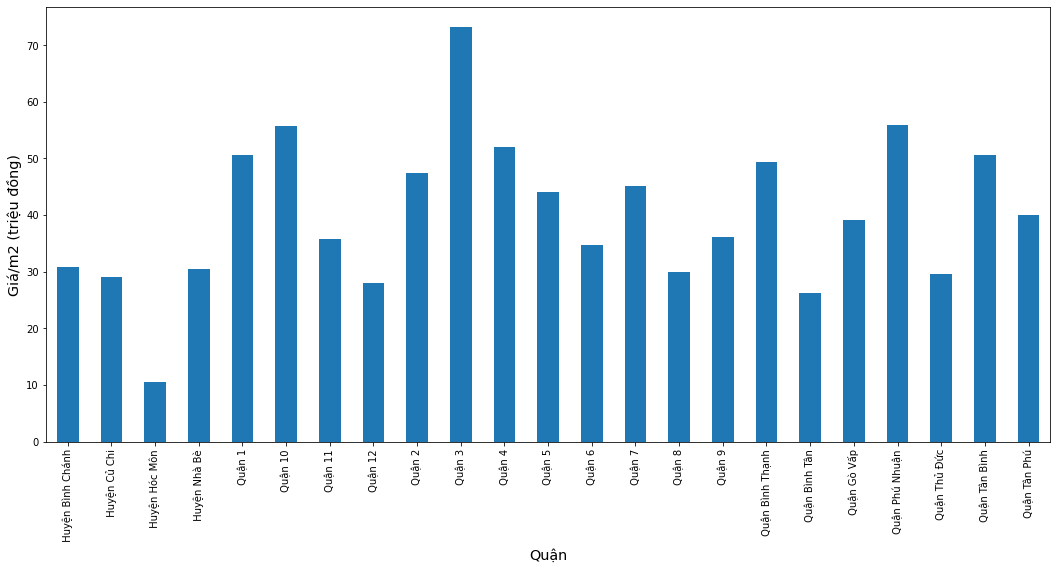

In [41]:
df.DienTich = pd.to_numeric(df.DienTich)
df.Phongngu = pd.to_numeric(df.Phongngu)
df.PhongTam = pd.to_numeric(df.PhongTam)
df.Gia = pd.to_numeric(df.Gia)
df.dtypes
df_temp = df.copy()
df_temp = (df_temp.groupby("Quan")["Gia"].sum()/df_temp.groupby("Quan")["DienTich"].sum()) / 1_000_000
plt.rcParams['figure.figsize'] = (18, 8)
plt.ylabel("Giá/m2 (triệu đồng)", fontsize="x-large")
df_temp.plot.bar()
plt.xlabel("Quận", fontsize="x-large")
plt.show()

## 2. Nội thất

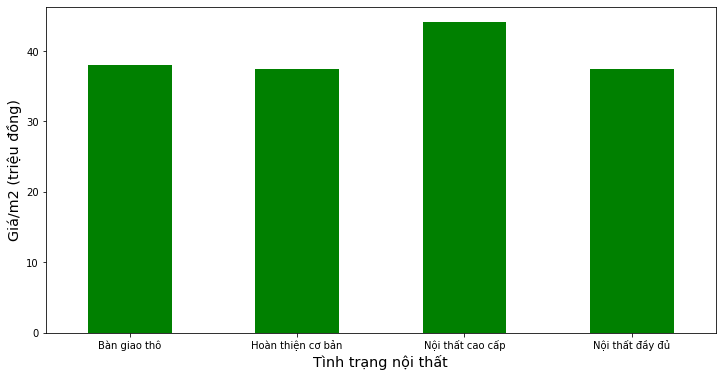

In [42]:
df_temp = df.copy()
df_temp = (df_temp.groupby("TinhTrangNoiThat")["Gia"].sum()/df_temp.groupby("TinhTrangNoiThat")["DienTich"].sum()) / 1_000_000
plt.rcParams['figure.figsize'] = (12, 6)
plt.ylabel("Giá/m2 (triệu đồng)", fontsize="x-large")
df_temp.plot.bar(color="green")
plt.xlabel("Tình trạng nội thất", fontsize="x-large")
plt.xticks(rotation=0)
plt.show()

## 3. Loại hình 

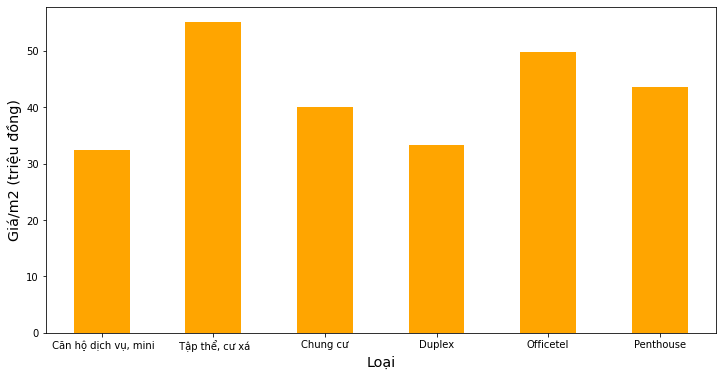

In [43]:
df_temp = df.copy()
df_temp = (df_temp.groupby("Loai")["Gia"].mean()/df_temp.groupby("Loai")["DienTich"].mean()) / 1_000_000
plt.rcParams['figure.figsize'] = (12, 6)
plt.ylabel("Giá/m2 (triệu đồng)", fontsize="x-large")
df_temp.plot.bar(color="orange")
plt.xlabel("Loại", fontsize="x-large")
plt.xticks(rotation=0)
plt.show()

## 4. Theo số lượng phòng

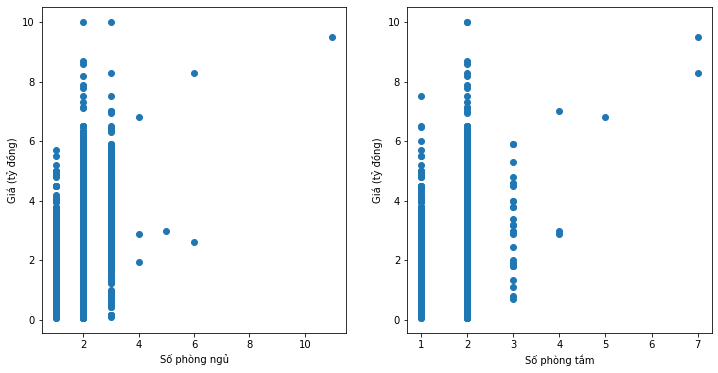

In [44]:
df_temp = df.copy()
plt.subplot(1,2,1)
plt.scatter(df_temp.Phongngu, df_temp.Gia/1_000_000_000)
plt.xlabel('Số phòng ngủ')
plt.ylabel('Giá (tỷ đồng)')
plt.subplot(1,2,2)
plt.scatter(df_temp.PhongTam, df_temp.Gia/1_000_000_000)
plt.xlabel('Số phòng tắm')
plt.ylabel('Giá (tỷ đồng)')
plt.show()

Theo quan sát: giá trị của bất động sản phân bố đồng đều giữa các số lượng phòng
#### => Số lượng phòng ngủ và phòng tắm không ảnh hưởng đến giá trị của bất động sản

## 5. Theo diện tích

Dễ dàng nhận thấy giá trị của bất động sản tỉ lệ thuận với diện tích của nó

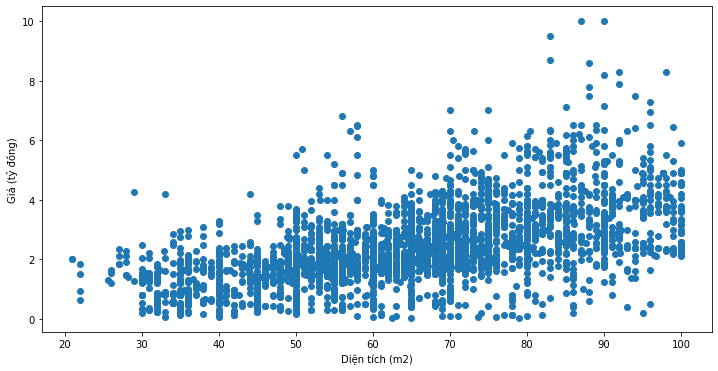

In [45]:
df_temp = df.copy()
plt.scatter(df_temp.DienTich, df_temp.Gia/1_000_000_000)
plt.xlabel('Diện tích (m2)')
plt.ylabel('Giá (tỷ đồng)')
plt.show()

## 6. Theo diện tích * số tầng

Phần thống kê này thể hiện giá trị của bất động sản theo diện tích thực tế có thể sử dụng (tính bằng cách lấy diện tích nhân với số tầng), từ đó có thể nhìn ra mối liên hệ giữa các trường này với nhau

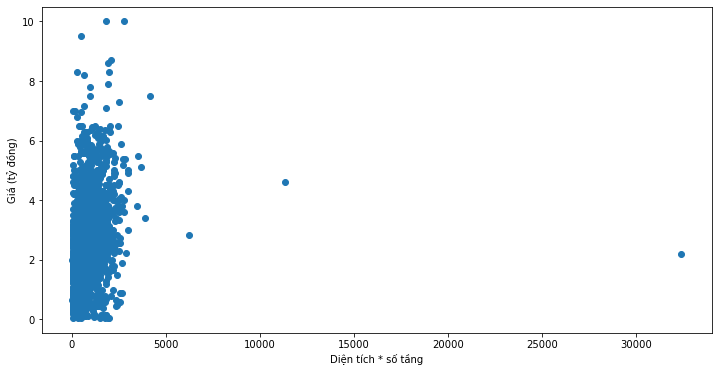

In [46]:
df_temp = df.copy()
plt.scatter(df_temp.SoTang*df_temp.DienTich, df_temp.Gia/1_000_000_000)
plt.xlabel('Diện tích * số tầng')
plt.ylabel('Giá (tỷ đồng)')
plt.show()

## 7. Theo tình trạng giấy tờ

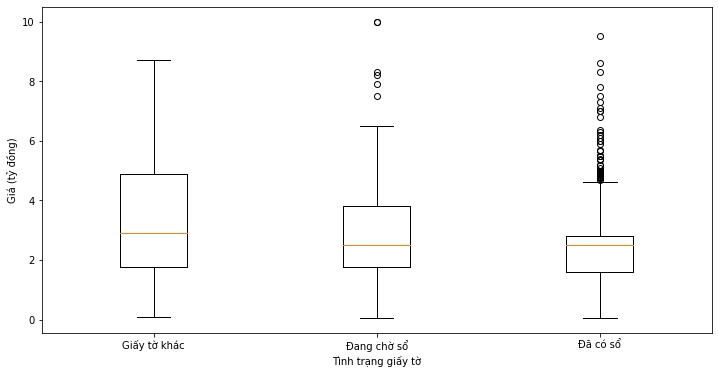

In [61]:
df_temp = df.copy()
plt.boxplot((df[df.GiayTo=='Giấy tờ khác'].Gia/1_000_000_000, df[df.GiayTo=='Đang chờ sổ'].Gia/1_000_000_000, df[df.GiayTo=='Đã có sổ'].Gia/1_000_000_000)
            ,labels=['Giấy tờ khác', 'Đang chờ sổ', 'Đã có sổ'])
plt.xlabel('Tình trạng giấy tờ')
plt.ylabel('Giá (tỷ đồng)')
plt.show()

Nhận thấy là tình trạng giấy tờ của nhà đất ảnh hưởng đến giá trị bất động sản
>mean, min và lower whisker của 3 loại tình trạng giấy tờ khá tương đồng nhau
<!-- -->
Giấy tờ khác
>Giá trị bất động sản của 'Giấy tờ khác' lệch âm\
>Max cao hơn so với 2 loại tình trạng giấy tờ còn lại
<!-- -->
Đang chờ sổ
>Giá trị bất động sản của 'Đang chờ sổ' lệch âm\
>Khác biệt với loại 'Giấy tờ khác', phần trực quan của 'Đang chờ sổ' có vài điểm ngoại lệ, và đỉnh max cũng thấp hơn
<!-- -->
Đã có sổ
>Giá trị bất động sản của 'Đã có sổ' lệch dương\
>Đỉnh max thấp nhất trong 3 loại\
>Có nhiều điểm ngoại lệ nhất